# multi-label classification 

In [2]:
import pandas as pd

In [3]:


df = pd.read_csv('../assets/books_1.Best_Books_Ever.csv')

print(df.info())

# Output of the first 5 rows of the table
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             52478 non-null  object 
 1   series            23470 non-null  object 
 2   author            52478 non-null  object 
 3   rating            52478 non-null  float64
 4   description       51140 non-null  object 
 5   language          48672 non-null  object 
 6   isbn              52478 non-null  object 
 7   genres            52478 non-null  object 
 8   characters        52478 non-null  object 
 9   bookFormat        51005 non-null  object 
 10  edition           4955 non-null   object 
 11  pages             50131 non-null  object 
 12  publisher         48782 non-null  object 
 13  publishDate       51598 non-null  object 
 14  firstPublishDate  31152 non-null  object 
 15  awards            52478 non-null  object 
 16  numRatings        52478 non-null  int64 

In [4]:
df = (df.query('genres != "[]"')
    .dropna(subset=['description'])
)

In [5]:
df.genres.value_counts()

genres
['Fiction']                                                                                                                                                                     202
['Fantasy']                                                                                                                                                                     168
['Poetry']                                                                                                                                                                      128
['Nonfiction']                                                                                                                                                                   95
['Childrens']                                                                                                                                                                    88
                                                                                             

In [29]:
df.head()

,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,...,publishDate,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,bbeScore,bbeVotes,price
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,"WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by f...",English,9.78044E+12,"['Young Adult', 'Fiction', 'Dystopia', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure', 'Teen', 'Post Apocalyptic', 'Action']","['Katniss Everdeen', 'Peeta Mellark', 'Cato (Hunger Games)', 'Primrose Everdeen', 'Gale Hawthorne', 'Effie Trinket', 'Haymitch Abernathy', 'Cinna', 'President Coriolanus Snow', 'Rue', 'Flavius', 'Lavinia (Hunger Games)', 'Marvel', 'Glimmer', 'Clove', 'Foxface', 'Thresh', 'Greasy Sae', 'Madge Und...",Hardcover,...,09/14/08,NaN,"['Locus Award Nominee for Best Young Adult Book (2009)', 'Georgia Peach Book Award (2009)', 'Buxtehuder Bulle (2009)', 'Golden Duck Award for Young Adult (Hal Clement Award) (2009)', ""Grand Prix de l'Imaginaire Nominee for Roman jeunesse étranger (2010)"", 'Books I Loved Best Yearly (BILBY) Award...",6376780,"['3444695', '1921313', '745221', '171994', '93557']",96.0,"['District 12, Panem', 'Capitol, Panem', 'Panem (United States)']",2993816,30516,5.09
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,"There is a door at the end of a silent corridor. And it’s haunting Harry Pottter’s dreams. Why else would he be waking in the middle of the night, screaming in terror?Harry has a lot on his mind for this, his fifth year at Hogwarts: a Defense Against the Dark Arts teacher with a personality like...",English,9.78044E+12,"['Fantasy', 'Young Adult', 'Fiction', 'Magic', 'Childrens', 'Adventure', 'Audiobook', 'Middle Grade', 'Classics', 'Science Fiction Fantasy']","['Sirius Black', 'Draco Malfoy', 'Ron Weasley', 'Petunia Dursley', 'Vernon Dursley', 'Dudley Dursley', 'Severus Snape', 'Rubeus Hagrid', 'Lord Voldemort', 'Minerva McGonagall', 'Neville Longbottom', 'Fred Weasley', 'George Weasley', 'Percy Weasley', 'Ginny Weasley', 'Colin Creevey', 'Filius Flit...",Paperback,...,09/28/04,06/21/03,"['Bram Stoker Award for Works for Young Readers (2003)', 'Anthony Award for Young Adult (2004)', ""Mythopoeic Fantasy Award for Children's Literature (2008)"", 'Audie Award for Audiobook of the Year (2004)', 'Books I Loved Best Yearly (BILBY) Awards for Older Readers (2004)', 'Colorado Blue Spruce...",2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,"['Hogwarts School of Witchcraft and Wizardry (United Kingdom)', 'London, England']",2632233,26923,7.38
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it, To Kill A Mockingbird became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into a...",English,1E+13,"['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Novels', 'Read For School', 'High School']","['Scout Finch', 'Atticus Finch', 'Jem Finch', 'Arthur Radley', 'Mayella Ewell', 'Aunt Alexandra', 'Bob Ewell', 'Calpurnia (housekeeper)', 'Tom Robinson', 'Miss Maudie Atkinson', 'Judge John Taylor', 'Dill Harris', 'Heck Tate', 'Stephanie Crawford']",Paperback,...,05/23/06,07-11-1960,"['Pulitzer Prize for Fiction (1961)', 'Audie Award for Classic (2007)', 'National Book Award Finalist for Fiction (1961)', 'Alabama Author Award for Fiction (1961)']",4501075,"['2363896', '1333153', '573280', '149952', '80794']",95.0,"['Maycomb, Alabama (United States)']",2269402,23328,NaN
3,Pride and Prejudice,N

In [6]:
# copy from: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [7]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [10]:
books = df[['title','description','genres']]

In [31]:
from ast import literal_eval
books['genres'] = books['genres'].apply(literal_eval)
all_categories = sum(books['genres'], [])


/var/folders/nq/9vkk1x4j3791_ywhx015m2rh0000gn/T/ipykernel_25464/675070531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['genres'] = books['genres'].apply(literal_eval)


In [33]:
len(set(all_categories))

982

In [35]:
len(all_categories)

404192

In [39]:
all_genres = nltk.FreqDist(all_categories) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

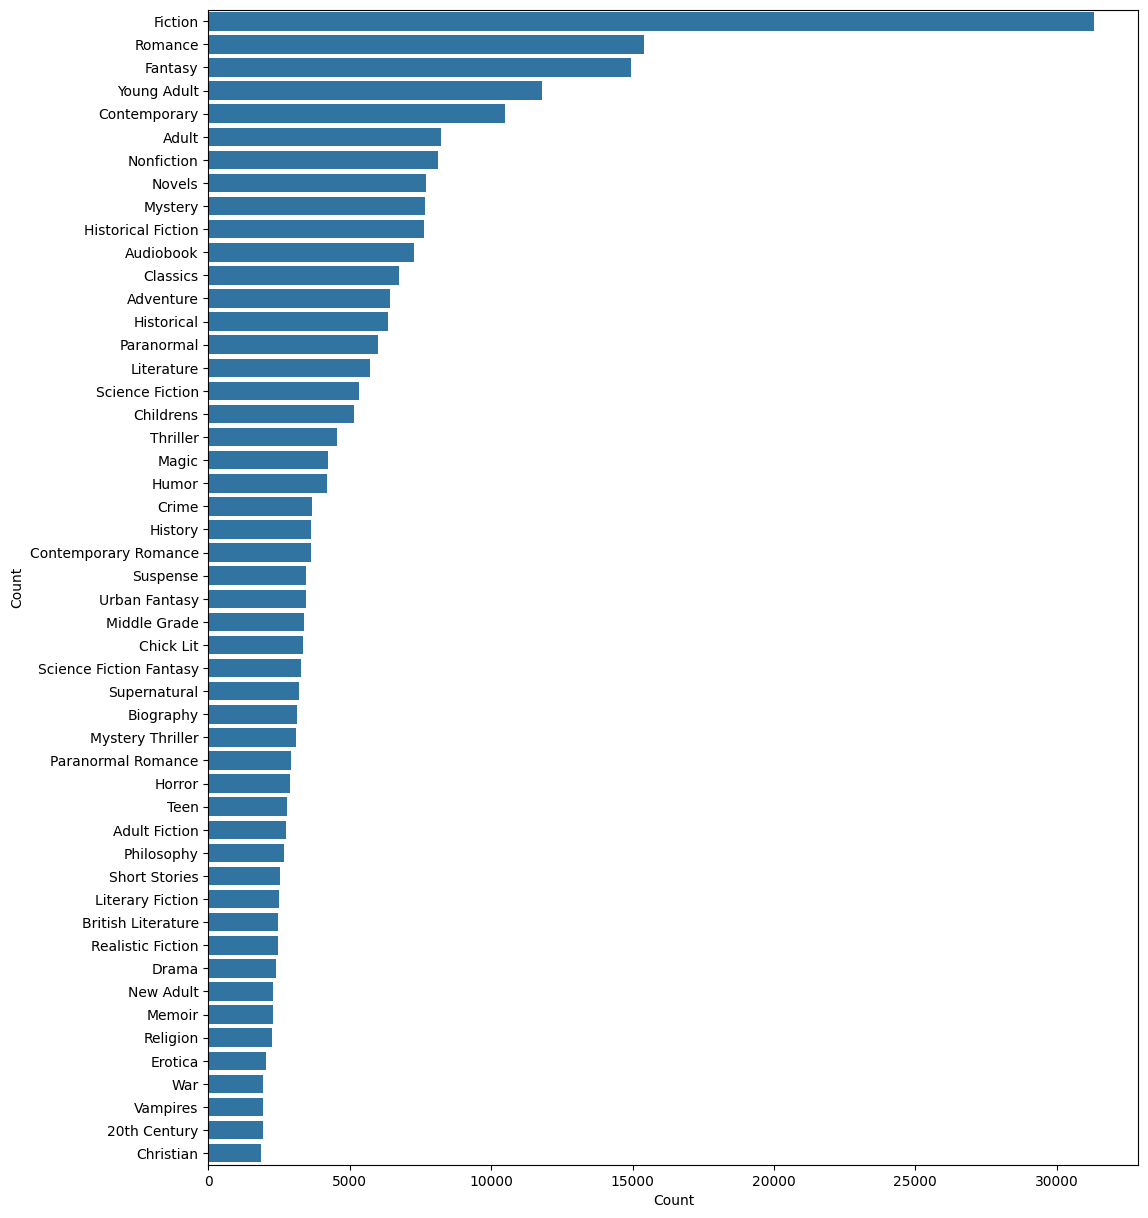

In [43]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [108]:
# remove all genres below 50 counts
top_boks = all_genres_df.query('Count > 100')
remove_books = all_genres_df.query('Count < 100')['Genre'].tolist()

In [107]:
remove_books

['Young Adult',
 'Fiction',
 'Dystopia',
 'Fantasy',
 'Science Fiction',
 'Romance',
 'Adventure',
 'Teen',
 'Post Apocalyptic',
 'Action',
 'Magic',
 'Childrens',
 'Audiobook',
 'Middle Grade',
 'Classics',
 'Science Fiction Fantasy',
 'Historical Fiction',
 'School',
 'Literature',
 'Historical',
 'Novels',
 'Read For School',
 'High School',
 'Historical Romance',
 'Classic Literature',
 'Adult',
 'Vampires',
 'Paranormal',
 'Paranormal Romance',
 'Supernatural',
 'Urban Fantasy',
 'War',
 'Holocaust',
 'World War II',
 'Books About Books',
 'Politics',
 'Christian',
 'Christian Fiction',
 'Epic Fantasy',
 'High Fantasy',
 'Civil War',
 'Contemporary',
 'Realistic Fiction',
 'Coming Of Age',
 'Drama',
 'Love',
 'Humor',
 'Comedy',
 'Picture Books',
 'Poetry',
 'Juvenile',
 'Kids',
 'Short Stories',
 'Gothic',
 '19th Century',
 'Mystery',
 'Thriller',
 'Suspense',
 'Mystery Thriller',
 'Crime',
 'Japan',
 'Asia',
 'Adult Fiction',
 'Horror',
 'LGBT',
 'British Literature',
 'France',

In [109]:
# remove categories with less than 100 counts
books['new_genres'] = books['genres'].apply(lambda genre_list: [genre for genre in genre_list if genre not in remove_books])

books = books.dropna(subset=['new_genres','description'])


In [57]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text
books['description'] = books['description'].apply(lambda x: clean_text(x))


In [110]:
books.new_genres.tolist()

[['Young Adult',
  'Fiction',
  'Dystopia',
  'Fantasy',
  'Science Fiction',
  'Romance',
  'Adventure',
  'Teen',
  'Post Apocalyptic',
  'Action'],
 ['Fantasy',
  'Young Adult',
  'Fiction',
  'Magic',
  'Childrens',
  'Adventure',
  'Audiobook',
  'Middle Grade',
  'Classics',
  'Science Fiction Fantasy'],
 ['Classics',
  'Fiction',
  'Historical Fiction',
  'School',
  'Literature',
  'Young Adult',
  'Historical',
  'Novels',
  'Read For School',
  'High School'],
 ['Classics',
  'Fiction',
  'Romance',
  'Historical Fiction',
  'Literature',
  'Historical',
  'Novels',
  'Historical Romance',
  'Classic Literature',
  'Adult'],
 ['Young Adult',
  'Fantasy',
  'Romance',
  'Vampires',
  'Fiction',
  'Paranormal',
  'Paranormal Romance',
  'Supernatural',
  'Teen',
  'Urban Fantasy'],
 ['Historical Fiction',
  'Fiction',
  'Young Adult',
  'Historical',
  'Classics',
  'War',
  'Holocaust',
  'World War II',
  'Books About Books',
  'Audiobook'],
 ['Classics',
  'Fiction',
  'Dyst

In [92]:
books.sample(3)


,title,description,genres,new_genres
8391,Syrian Folktales,this delightful book relates folktales from various regions of syria each folktale is located on a regional map and is accompanied by a local related recipe,[Mythology],[Mythology]
26310,Hitch 22: A Memoir,over the course of his years christopher hitchens has been a citizen of both the united states and the united kingdom he has been both a socialist opposed to the war in vietnam and a supporter of the u s war against islamic extremism in iraq he has been both a foreign correspondent in some of th...,"[Nonfiction, Biography, Memoir, Politics, Autobiography, History, Biography Memoir, Atheism, Philosophy, Religion]","[Nonfiction, Biography, Memoir, Politics, Autobiography, History, Biography Memoir, Atheism, Philosophy, Religion]"
43942,Clouds,this new paperback edition of aristophanes popular play includes the complete greek text and extensive notes and commentary dover examines the two versions of the play recounts the history of the text and analyzes a number of problems surrounding the plays overall interpretation including the gr...,"[Classics, Plays, Drama, Fiction, Philosophy, Literature, Humor, Theatre, Comedy, Ancient]","[Classics, Plays, Drama, Fiction, Philosophy, Literature, Humor, Theatre, Comedy, Ancient]"


In [111]:
all_new_genres = sum(books['new_genres'], [])

In [112]:
len(set(all_new_genres))

323

In [113]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})